Dataset: https://zenodo.org/records/3549595

In [1]:
import torch

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

device

'cpu'

# **Supervised Learning on the Labeled Dataset**

## Data Preprocessing

In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json here

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mexwell/lidar-data-for-tree-species-classification
!unzip -o lidar-data-for-tree-species-classification.zip -d lidar-data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mexwell/lidar-data-for-tree-species-classification
License(s): Attribution 4.0 International (CC BY 4.0)
100% 81.0M/81.0M [00:00<00:00, 842MB/s]
100% 81.0M/81.0M [00:00<00:00, 839MB/s]
Archive:  lidar-data-for-tree-species-classification.zip
  inflating: lidar-data/dataset_1_training_test.csv  
  inflating: lidar-data/dataset_1_unlabeled_set.csv  
  inflating: lidar-data/dataset_2_training_test.csv  
  inflating: lidar-data/dataset_2_unlabeled_set.csv  


In [3]:
from data_preprocessing import process_labeled_data

In [4]:
full_labeled_df = process_labeled_data(
    ['/content/lidar-data/dataset_1_training_test.csv',
     '/content/lidar-data/dataset_2_training_test.csv']
    )
full_labeled_df.head()

,zmean,zsd,zskew,zkurt,zentropy,imean,isd,iskew,ikurt,ipcumzq30,ipcumzq50,ipcumzq70,dtm,aspect,slope,Species,Species Number
0,0.000000,0.015868,0.347542,0.005737,0.396236,0.142131,0.082381,0.201176,0.027792,0.451379,0.438797,0.398530,0.774774,0.603841,0.366868,Green alder,5
1,0.000676,0.016100,0.348519,0.006269,0.414225,0.720889,0.709801,0.229452,0.018400,0.342682,0.260413,0.236177,0.834930,0.496024,0.389383,European Larch,1
2,0.002541,0.020247,0.344087,0.007119,0.421639,0.185853,0.137224,0.239136,0.028446,0.400164,0.449852,0.552638,0.912703,0.731446,0.498175,Green alder,5
3,0.003840,0.025313,0.353304,0.006561,0.475403,0.124606,0.073536,0.235840,0.045376,0.388518,0.405317,0.477046,0.785316,0.790922,0.410597,Green alder,5
4,0.004566,0.022959,0.344277,0.005614,0.452551,0.099862,0.049907,0.144789,0.006673,0.399161,0.430855,0.440310,0.228426,0.212406,0.240561,Other broadleaves,2


## Data Splitting

In [5]:
import torch
import data_splitting

In [6]:
train_dataset, val_dataset, test_dataset, full_dataset = data_splitting.get_labeled_datasets(
    full_labeled_df,
    smote = True,
    smote_scaling_dict = {0: 1, 1: 1, 2: 1, 3: 1.5,
                          4: 2, 5: 2, 6: 3, 7: 4}
    )

In [7]:
train_class_counts = torch.zeros(8).to(device)
for _, label in train_dataset:
    train_class_counts += label

train_class_counts, train_class_counts.sum()

(tensor([769., 277., 261., 327., 182., 142., 138., 112.]), tensor(2208.))

## Model Construction and Training

In [8]:
import torch
import math
from torch.utils.data import DataLoader
from torch import nn

In [9]:
from tree_classifier import TreeClassifier
from tree_classifier import plot_training_progress

In [10]:
# Choosing hyperparameters
batch_size = 1000
learning_rate = 5e-3
epochs = 200

# class weights
w = torch.tensor([1/(1 + math.log(n))**2 for n in train_class_counts]).to(device)
w = w/torch.linalg.norm(w)
w

tensor([0.2411, 0.3211, 0.3270, 0.3056, 0.3661, 0.3973, 0.4011, 0.4309])

In [16]:
# instantiate model
model = TreeClassifier()

# define dataloaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)

# choose loss function and optimization algorithm
loss_fn = nn.CrossEntropyLoss(
                              weight = w
                              )
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# train model
history = model.fit(train_dataloader, val_dataloader, loss_fn,
                    optimizer, epochs, verbose = 1)

Epoch 1
Train Accuracy: 35.356%, Avg loss: 0.703924, Val Accuracy: 42.177%, Avg loss: 0.543584

-------------------------------
Epoch 2
Train Accuracy: 35.356%, Avg loss: 0.682709, Val Accuracy: 42.177%, Avg loss: 0.585017

-------------------------------
Epoch 3
Train Accuracy: 35.356%, Avg loss: 0.677201, Val Accuracy: 42.177%, Avg loss: 0.589126

-------------------------------
Epoch 4
Train Accuracy: 35.356%, Avg loss: 0.663100, Val Accuracy: 42.177%, Avg loss: 0.581131

-------------------------------
Epoch 5
Train Accuracy: 35.356%, Avg loss: 0.636684, Val Accuracy: 42.177%, Avg loss: 0.566915

-------------------------------
Epoch 6
Train Accuracy: 35.310%, Avg loss: 0.611048, Val Accuracy: 42.177%, Avg loss: 0.559431

-------------------------------
Epoch 7
Train Accuracy: 26.369%, Avg loss: 0.576368, Val Accuracy: 21.315%, Avg loss: 0.537689

-------------------------------
Epoch 8
Train Accuracy: 13.960%, Avg loss: 0.541843, Val Accuracy: 6.576%, Avg loss: 0.518340

---------

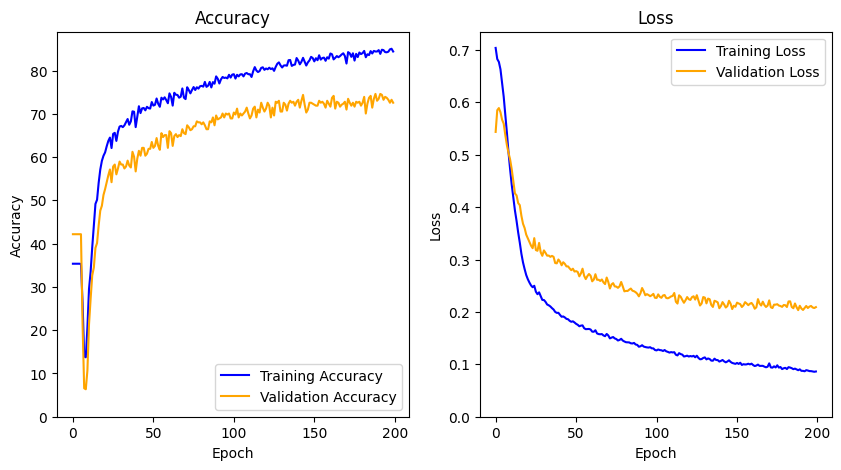

In [ ]:
plot_training_progress(history)

In [17]:
# torch.save(model, 'weights_trained_on_real.pth')
model = torch.load('weights_trained_on_real.pth', weights_only = False).to(device)
model.eval()

TreeClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=8, bias=True)
  )
)

## Testing

In [19]:
import model_metrics

In [20]:
batch_size = 1024
model.eval()

TreeClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=8, bias=True)
  )
)

In [21]:
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
full_dataloader = DataLoader(full_dataset, batch_size = batch_size)

Norway Spruce:  0.824
European Larch:  0.630
Other broadleaves:  0.851
Silver fir:  0.849
Broadleaves:  0.909
Green alder:  0.900
Pines:  0.609
Scots Pine:  0.714
Macro F1 Score:  0.786
Accuracy: 80.272%, Avg loss: 0.165806


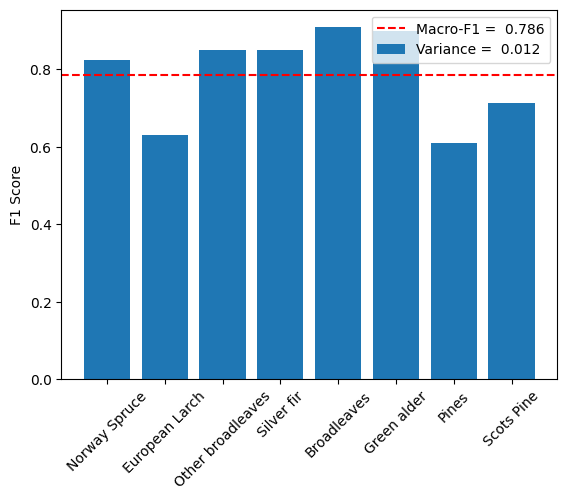

In [22]:
model_metrics.print_f1_scores(model, val_dataloader)
model.evaluate_accuracy(val_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, val_dataloader)

Norway Spruce:  0.830
European Larch:  0.673
Other broadleaves:  0.843
Silver fir:  0.785
Broadleaves:  0.911
Green alder:  0.957
Pines:  0.571
Scots Pine:  0.673
Macro F1 Score:  0.781
Accuracy: 80.245%, Avg loss: 0.172745


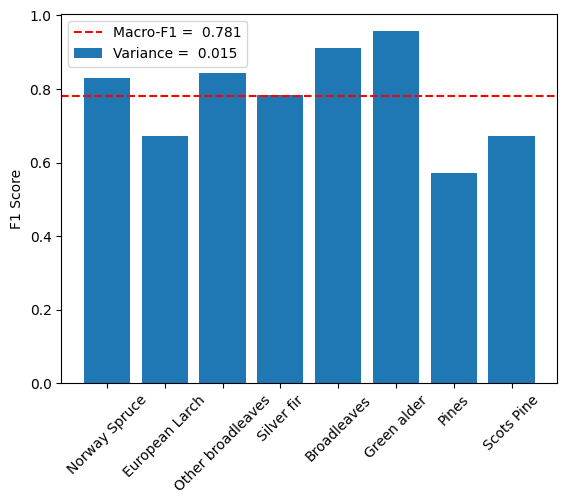

In [23]:
model_metrics.print_f1_scores(model, test_dataloader)
model.evaluate_accuracy(test_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, test_dataloader)

Norway Spruce:  0.824
European Larch:  0.661
Other broadleaves:  0.820
Silver fir:  0.778
Broadleaves:  0.883
Green alder:  0.933
Pines:  0.582
Scots Pine:  0.711
Macro F1 Score:  0.774
Accuracy: 79.314%, Avg loss: 0.173852


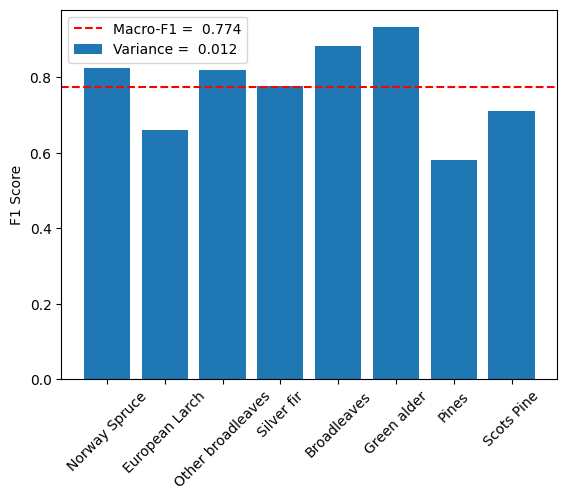

In [24]:
model_metrics.print_f1_scores(model, full_dataloader)
model.evaluate_accuracy(full_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, full_dataloader)

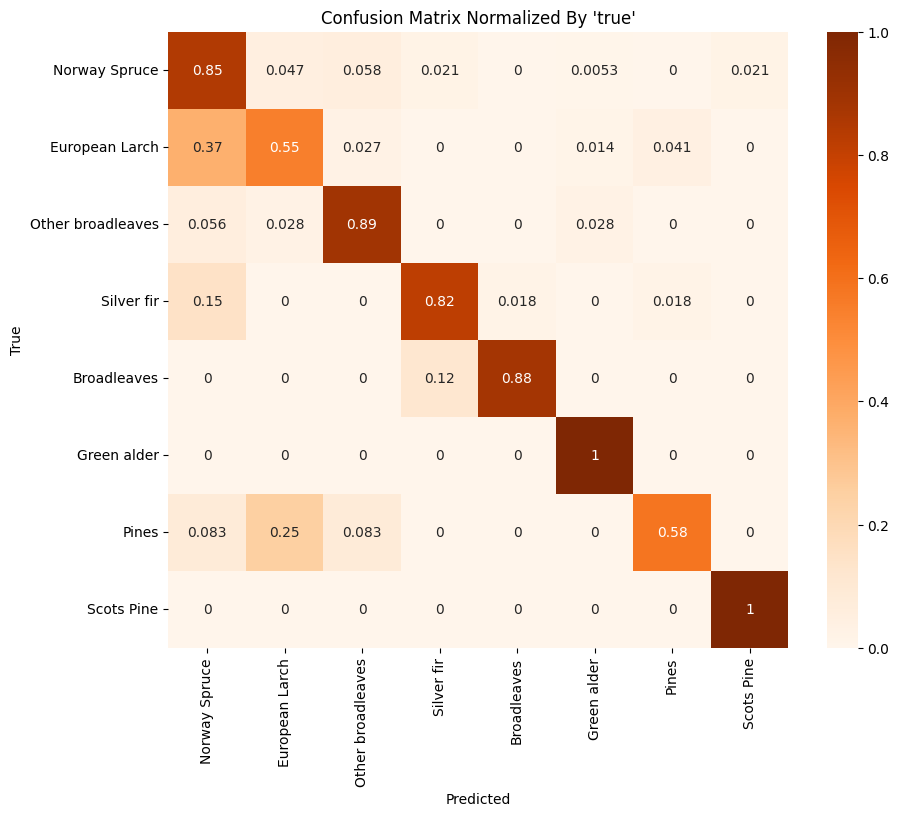

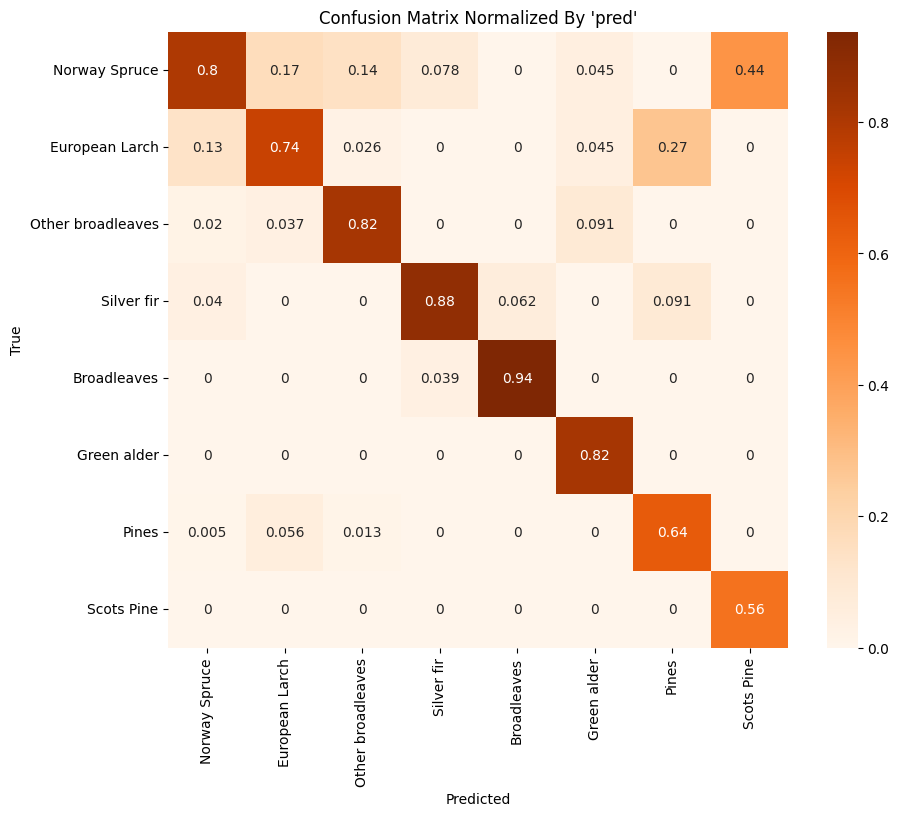

In [25]:
model_metrics.plot_confusion_matrix(model, val_dataloader, normalize = 'true')
model_metrics.plot_confusion_matrix(model, val_dataloader, normalize = 'pred')

# **Unsupervised Learning on Unlabeled Data**

## Data Preprocessing

In [ ]:
import torch

In [ ]:
from data_preprocessing import process_unlabeled_data
from data_splitting import get_pseudo_labeled_dataframe, get_pseudo_labeled_datasets

In [ ]:
full_unlabeled_df = process_unlabeled_data(
    ['/content/lidar-data/dataset_1_unlabeled_set.csv',
     '/content/lidar-data/dataset_2_unlabeled_set.csv']
)

len(full_unlabeled_df)

589040

In [ ]:
model = torch.load('weights_trained_on_real.pth', weights_only = False)
model.eval()

TreeClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=8, bias=True)
  )
)

In [ ]:
full_pseudo_labeled_df = get_pseudo_labeled_dataframe(model, full_unlabeled_df)

<Axes: >

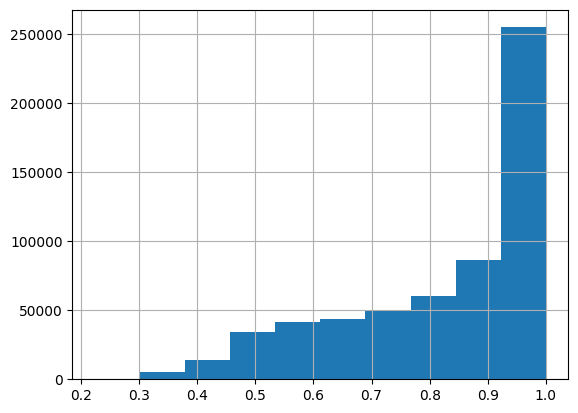

In [ ]:
full_pseudo_labeled_df['Prediction Confidence'].hist()

## Data Splitting

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
from data_splitting import get_pseudo_labeled_datasets

In [ ]:
train_pseudo_dataset = get_pseudo_labeled_datasets(
    model,
    full_pseudo_labeled_df,
    threshold = 0.75,
    smote = False,
    smote_scaling_dict = {0: 1,
                          1: 1.5,
                          2: 1.5,
                          3: 1.5,
                          4: 2,
                          5: 2,
                          6: 2,
                          7: 2}
    )

In [ ]:
len(train_pseudo_dataset)

412444

In [ ]:
train_pseudo_class_counts = torch.zeros(8).to(device)
for _, label in train_pseudo_dataset:
    train_pseudo_class_counts += label

train_pseudo_class_counts, train_pseudo_class_counts.sum()

(tensor([116035.,  16770., 125213.,  38035.,  56755.,  49642.,   7659.,   2335.],
        device='cuda:0'),
 tensor(412444., device='cuda:0'))

## Re-training Model On Pseudo-Labeled Data

In [ ]:
import torch
import math
from torch.utils.data import DataLoader
from torch import nn

In [ ]:
from tree_classifier import TreeClassifier, plot_training_progress

In [ ]:
model = torch.load('weights_train_on_real.pth', weights_only = False)
model.to(device)
model.eval()

TreeClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=8, bias=True)
  )
)

In [ ]:
len(train_pseudo_dataset)

412444

In [ ]:
# Choosing hyperparameters
batch_size = 30000
learning_rate = 2.5e-4
epochs = 20

# class weights
w = torch.tensor([1/(1 + math.log(n)**(1/3)) for n in train_pseudo_class_counts]).to(device)
w = w/torch.linalg.norm(w)
w

tensor([0.3424, 0.3570, 0.3419, 0.3505, 0.3475, 0.3485, 0.3638, 0.3756],
       device='cuda:0')

In [ ]:
# define dataloaders
train_pseudo_dataloader = DataLoader(train_pseudo_dataset, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)

# choose loss function and optimization algorithm
loss_fn = nn.CrossEntropyLoss(
                              weight = w
                              )
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# train model
history = model.fit(train_pseudo_dataloader, val_dataloader, loss_fn,
                    optimizer, epochs, verbose = 1)

Epoch 1
Train Accuracy: 99.823%, Avg loss: 0.021182, Val Accuracy: 78.458%, Avg loss: 0.215161

-------------------------------
Epoch 2
Train Accuracy: 99.732%, Avg loss: 0.018725, Val Accuracy: 78.458%, Avg loss: 0.224137

-------------------------------
Epoch 3
Train Accuracy: 99.877%, Avg loss: 0.015372, Val Accuracy: 77.778%, Avg loss: 0.223446

-------------------------------
Epoch 4
Train Accuracy: 99.899%, Avg loss: 0.013742, Val Accuracy: 78.231%, Avg loss: 0.227984

-------------------------------
Epoch 5
Train Accuracy: 99.873%, Avg loss: 0.012606, Val Accuracy: 78.458%, Avg loss: 0.234734

-------------------------------
Epoch 6
Train Accuracy: 99.881%, Avg loss: 0.011621, Val Accuracy: 78.231%, Avg loss: 0.238831

-------------------------------
Epoch 7
Train Accuracy: 99.884%, Avg loss: 0.010789, Val Accuracy: 78.458%, Avg loss: 0.243051

-------------------------------
Epoch 8
Train Accuracy: 99.879%, Avg loss: 0.010192, Val Accuracy: 78.685%, Avg loss: 0.247207

--------

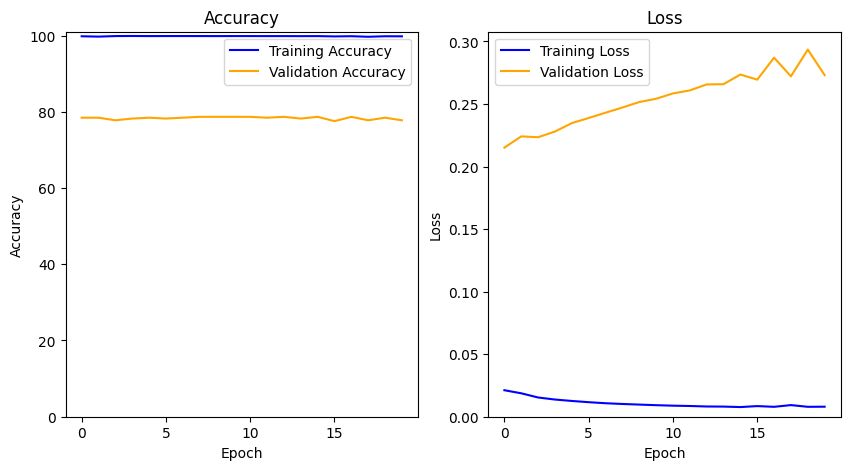

In [ ]:
plot_training_progress(history)

In [ ]:
# torch.save(model, 'weights_trained_on_pseudo.pth')
model = torch.load('weights_trained_on_pseudo.pth', weights_only = False).to(device)
model.eval()

TreeClassifier(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=15, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=8, bias=True)
  )
)

## Testing

In [ ]:
import model_metrics

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size)

Norway Spruce:  0.822
European Larch:  0.566
Other broadleaves:  0.781
Silver fir:  0.803
Broadleaves:  0.816
Green alder:  0.914
Pines:  0.667
Scots Pine:  0.609
Macro F1 Score:  0.747
Accuracy: 77.778%, Avg loss: 0.273122


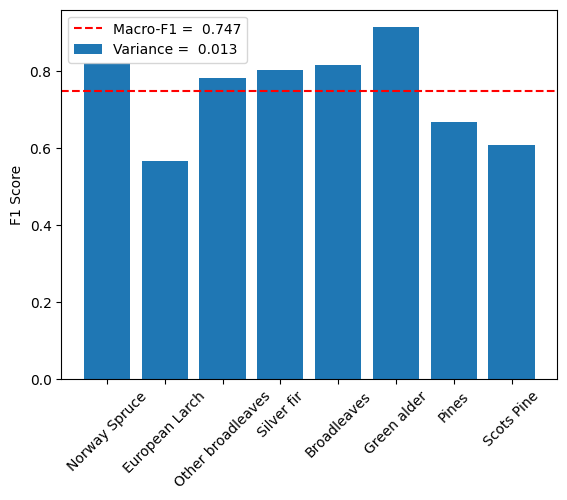

In [ ]:
model_metrics.print_f1_scores(model, val_dataloader)
model.evaluate_accuracy(val_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, val_dataloader)

Norway Spruce:  0.814
European Larch:  0.601
Other broadleaves:  0.804
Silver fir:  0.779
Broadleaves:  0.858
Green alder:  0.920
Pines:  0.588
Scots Pine:  0.696
Macro F1 Score:  0.758
Accuracy: 77.702%, Avg loss: 0.283817


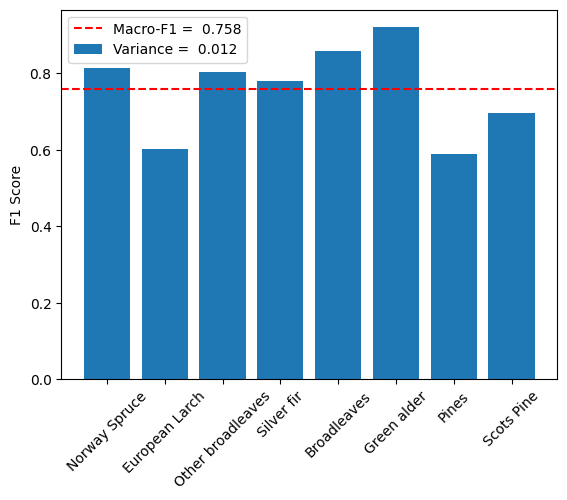

In [ ]:
model_metrics.print_f1_scores(model, test_dataloader)
model.evaluate_accuracy(test_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, test_dataloader)

Norway Spruce:  0.808
European Larch:  0.604
Other broadleaves:  0.804
Silver fir:  0.773
Broadleaves:  0.848
Green alder:  0.916
Pines:  0.577
Scots Pine:  0.667
Macro F1 Score:  0.749
Accuracy: 77.293%, Avg loss: 0.278145


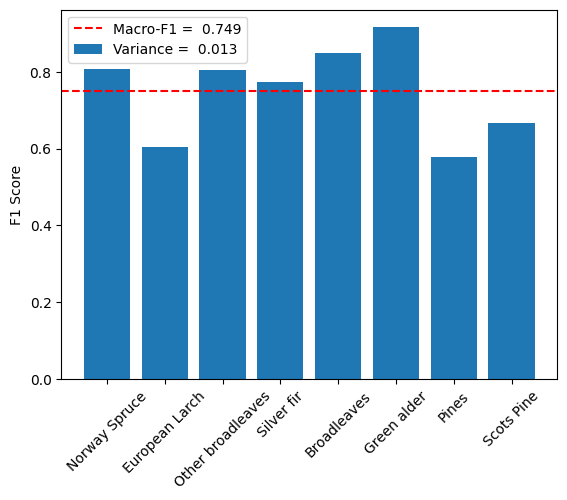

In [ ]:
model_metrics.print_f1_scores(model, full_dataloader)
model.evaluate_accuracy(full_dataloader, loss_fn)
model_metrics.plot_f1_scores(model, full_dataloader)